<a href="https://colab.research.google.com/github/Maksim2809/Old_HomeWork_Numerical_Methods/blob/main/HomeWork5_(%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D1%8F_%D1%81%D0%BF%D0%BB%D0%B0%D0%B9%D0%BD%D0%B0%D0%BC%D0%B8).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as sp
import statsmodels as st
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import sklearn.metrics

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, GridSearchCV

from sklearn.metrics import mean_squared_error as mse, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import itertools as itr

from sklearn.metrics import roc_auc_score as rocauc
from sklearn.linear_model import LogisticRegression , Ridge, Lasso,ElasticNet

import math

import matplotlib.pyplot as plt

In [ ]:
df_itog = pd.DataFrame({})

def f(x):
    """
    истинная, незашумлёная функция.
    """
    return np.sin(x)*np.log(1+x**2)

# Генерация данных
### (N = 100, т.к. иначе GSV не очень хорошо считается)

In [ ]:
N  = 100
s2 = 0.5
P = 10

X = np.random.uniform(low = -math.pi, high = math.pi, size = N)
E = np.random.normal(0,s2,N)
Y = f(X)+E
X_p = np.array([X**i for i in range(1,P)]).T
x_train,x_test,y_train,y_test = train_test_split(X_p,Y)

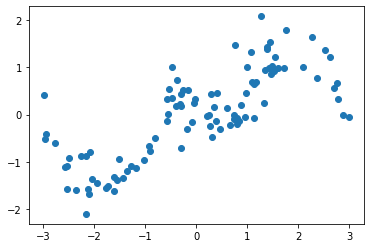

In [ ]:
plt.scatter(X,Y)



# Задание № 1. Выбор степени полинома для апроксимации

In [ ]:
for i in range(1,P):
    K = KFold( n_splits=5 )
    r2 = []
    for x1,x2 in K.split(x_train,y_train):
        x_tr = X_p[:,:i][x1]
        x_val= X_p[:,:i][x2]
        y_tr = Y[x1]
        y_val= Y[x2]
        lr = LinearRegression().fit(x_tr,y_tr)
        y_pred = lr.predict(x_test[:,:i])
        r2+=[r2_score(y_test,y_pred)]
    print(f'Среднее(степень полинома = {i}):',np.mean(r2))

Среднее(степень полинома = 1): 0.5946514753300771
Среднее(степень полинома = 2): 0.5816044701551386
Среднее(степень полинома = 3): 0.649863140321804
Среднее(степень полинома = 4): 0.6183981186699452
Среднее(степень полинома = 5): 0.7086653193662873
Среднее(степень полинома = 6): 0.6966338277402475
Среднее(степень полинома = 7): 0.7285667945804433
Среднее(степень полинома = 8): 0.7304982519977723
Среднее(степень полинома = 9): 0.7467584802632679


###### Начиная с седьмой степени результаы +- похожи. Поэтму выберем стпень полинома 7

In [ ]:
x_train,x_test, y_train,y_test = train_test_split(X_p[:,:6],Y)
ridge = Ridge(max_iter = 14000)
clf = GridSearchCV(ridge, param_grid={'alpha': [i/100 for i in range(101)]}).fit(x_train,y_train)
print(clf.best_params_)
print('R2',r2_score(y_test,clf.predict(x_test)))
# print('CGV:',np.mean(cross_val_score(clf, x_test, y_test, cv=5,scoring = 'r2')))

{'alpha': 1.0}
R2 0.7166888994353635


# Задание № 2 (строим сплайн без сглаживания)

In [ ]:
from sklearn.preprocessing import SplineTransformer
from scipy.interpolate import CubicSpline
from scipy.interpolate import splev, splrep
from scipy import interpolate

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(X,Y)

df_sort = pd.DataFrame({'x':x_train,
                       'y':y_train}).sort_values('x')
x_sort = df_sort['x']
y_sort = df_sort['y']
# cs = CubicSpline(df_sort['x'][:4],df_sort['y'][:4])
spl = splrep(df_sort['x'][::10], df_sort['y'][::10], s = 0)
y2 = splev(df_sort['x'], spl)
# Y_new2 = SplineTransformer().fit_transform([[x] for x in X], Y)
# Y_new3 = splrep

In [ ]:
def f_sp(x,X,Y):
    tck = interpolate.splrep(X, Y, s = 0)
    return interpolate.splev(x, tck)

x_sp3 = x_sort
x_axis = np.linspace(-math.pi,math.pi,100)
y_sp3 = f_sp( x_axis,x_sort[::5],y_sort[::5])

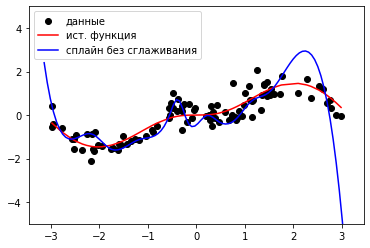

In [ ]:
df_sort_full = pd.DataFrame({'x':X,
                       'y':Y}).sort_values('x')
x_sort_full = df_sort_full['x']
y_sort_full = df_sort_full['y']

# df_itog['x'] = df_sort_full['x']
# df_itog['y'] = df_sort_full['y']
# df_itog['сплайн без сглжаивания'] = f_sp( x_sort_full,x_sort[::5],y_sort[::5])

plt.scatter(df_sort_full['x'],df_sort_full['y'],label = 'данные',color='k')
# plt.plot(df_sort['x'],cs(df_sort['x'],3))
# plt.plot(df_sort['x'],y2)
plt.plot(x_sort_full,f(x_sort_full),label = 'ист. функция',color='r')
plt.plot(x_axis,y_sp3,label = 'сплайн без сглаживания',color='b')
plt.legend()
plt.ylim((-5,5))
plt.show()

# Задание № 3 (выбор коэффициента сглаживания)

In [ ]:
K = KFold( n_splits=3,shuffle=True )
idx_fold = []
for x1,x2 in K.split(x_train,y_train):
    idx_fold+= [((x1,x2))]
for i in range(100):

    error = []
    for x1,x2 in idx_fold:
        df_sort = pd.DataFrame({'x':x_train[x1],
                       'y':y_train[x1]}).sort_values('x')

        df_sort_test = pd.DataFrame({'x':x_train[x2],
                       'y':y_train[x2]}).sort_values('x')

#         x_sort = df_sort['x']
#         y_sort = df_sort['y']

        spl2 = splrep(df_sort['x'][::5], df_sort['y'][::5], s = i/100)
        y_pred = splev(df_sort_test['x'], spl2)

#         y_sp3 = f_sp( x_test,x_sort[::40],y_sort[::40])
#         y_pred = lr.predict(x_test[:,:i])
        error+=[mse(y_train[x2],y_pred)]
    print(f'(коэф. сглаживания = {i/100}):',np.mean(error))
# plt.plot(df_sort_test['x'],y_pred,color='b')
# x_all = np.linspace(-math.pi,math.pi,100)
# plt.plot(x_all,splev(x_all, spl2),color='r')
# plt.scatter(x_train,y_train,color='k')
# plt.show()
# plt.scatter(x_train,y_train)

(коэф. сглаживания = 0.0): 6.89234176609926
(коэф. сглаживания = 0.01): 6.5916103678531
(коэф. сглаживания = 0.02): 6.472260054397613
(коэф. сглаживания = 0.03): 6.384990516315117
(коэф. сглаживания = 0.04): 6.312546536098658
(коэф. сглаживания = 0.05): 6.248827137910957
(коэф. сглаживания = 0.06): 6.1904909374231
(коэф. сглаживания = 0.07): 6.135465172696697
(коэф. сглаживания = 0.08): 6.081589045074337
(коэф. сглаживания = 0.09): 6.028032966274027
(коэф. сглаживания = 0.1): 6.008575019249796
(коэф. сглаживания = 0.11): 5.942170770263633
(коэф. сглаживания = 0.12): 5.878144472531674
(коэф. сглаживания = 0.13): 5.812929930928026
(коэф. сглаживания = 0.14): 5.746323820100432
(коэф. сглаживания = 0.15): 5.679071485083
(коэф. сглаживания = 0.16): 5.612474962605994
(коэф. сглаживания = 0.17): 5.526659288552687
(коэф. сглаживания = 0.18): 5.385474029300178
(коэф. сглаживания = 0.19): 5.296100530391496
(коэф. сглаживания = 0.2): 5.2215705807272
(коэф. сглаживания = 0.21): 5.155738199829737
(

In [ ]:
# spl3 = splrep(df_sort['x'][::8], df_sort['y'][::8], s = 0.99)
# df_itog['со сглаживанием'] = splev(df_sort_test['x'], spl3)

###### Лучший коэффициент = 0.99

In [ ]:
# import numpy as np
# from pygam import LinearGAM, s
# import matplotlib.pyplot as plt

# x_ax = df_sort_full['x']
# y_ax = df_sort_full['y']
# gam = LinearGAM(s(0)).fit(x_ax[::4],y_ax[::4] )

# # Generate predictions
# # X_pred = np.linspace(_, _, _)

# y_pred = gam.predict(x_ax)

# # Plot data and predictions
# plt.scatter(x_ax, df_sort_full['y'], label='data')
# plt.plot(x_ax, f(x_ax), 'k-', label='$f(x)$')
# plt.plot(x_ax, y_pred, label='Predictions GAM',color = 'r')
# plt.legend()
# plt.show()

# Выделить базисные функции из используемых методов проблематично (4-ое задание), пятое задание почти не отличается от 3го, поэтому без 4-го и 5-го заданий

# Задание 6 (визуализация моделей)

In [ ]:
df_itog['x'] = X
df_itog['y'] = Y
df_itog['ист функ'] = f(X)
df_itog['регрессия'] = clf.predict(X_p[:,:6])
df_itog['сплайн без сглаживания'] = f_sp( X,x_sort[::5],y_sort[::5])

spl3 = splrep(df_sort['x'][::5], df_sort['y'][::5], s = 0.99)
df_itog['со сглаживанием'] = splev(X, spl3)

<AxesSubplot:xlabel='x'>

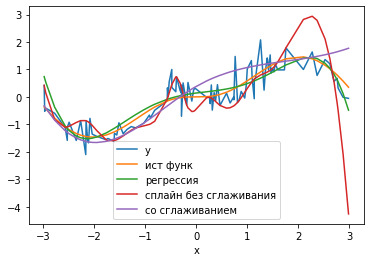

In [ ]:
df_itog.sort_values(by = 'x').plot(x = 'x')

##### Сравнение результатов (по R2)

In [ ]:
for col in df_itog.columns[3:]:
    print(f'{col}:',r2_score(df_itog['ист функ'],df_itog[col]))

регрессия: 0.915323442541041
сплайн без сглаживания: 0.30571545163412894
со сглаживанием: 0.7719225327189072
